In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd

plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
def load(filename):
    x = pd.read_csv(os.path.join('../data/jhu/csse_covid_19_data', filename))
    x = x.drop(columns=['Lat', 'Long']).set_index(['Country/Region', 'Province/State']).T
    x.index = pd.to_datetime(x.index, dayfirst=False)
    x.index.name = 'Date'
    return x.groupby(axis='columns', level='Country/Region').sum()
total_deaths = load('csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [3]:
jhu_codes_file = 'UID_ISO_FIPS_LookUp_Table.csv'
jhu_codes = pd.read_csv(os.path.join('../data/jhu/csse_covid_19_data', jhu_codes_file))
top_level = jhu_codes['Province_State'].isnull()
iso_jhu_map = jhu_codes.loc[top_level, ['iso3','Country_Region']].drop_duplicates()
iso_codes_file = 'code_map.csv'
iso_code_map = pd.read_csv(os.path.join('../data', iso_codes_file))
un_iso_map = iso_code_map[['country-code', 'alpha-3']].drop_duplicates()

In [4]:
POPULATION_YEAR = '2019'
pop_file = os.path.join('../data/un', 'WPP2019_POP_F01_1_TOTAL_POPULATION_BOTH_SEXES.xlsx')
pop_df = pd.read_excel(pop_file, skiprows=16, sheet_name='ESTIMATES')
pop_by_jhu = (pop_df
 .merge(un_iso_map, left_on='Country code', right_on='country-code')
 .merge(iso_jhu_map, left_on='alpha-3', right_on='iso3')
).set_index('Country_Region')[POPULATION_YEAR] * 1000 / 100000
# UN data is in thousands, convert to deaths per 100k population

In [5]:
daily_deaths = total_deaths.diff()
daily_deaths_avg = daily_deaths.rolling(7, center=True, min_periods=7).mean()

In [6]:
MIN_DAILY_DEATHS = 100

columns = {}
for idx, column in daily_deaths_avg.iteritems():
    if column.max() < MIN_DAILY_DEATHS:
        continue
    first_date = column[column >= MIN_DAILY_DEATHS].first_valid_index()
    new_col = column.loc[first_date:].reset_index(drop=True)
    columns[idx] = new_col
#     columns[idx] = column
comparable_deaths = pd.DataFrame(columns)
comparable_deaths = comparable_deaths.reindex(columns=comparable_deaths.ffill().iloc[-1].sort_values(ascending=False).index)

(50, 3627.2616075976175)

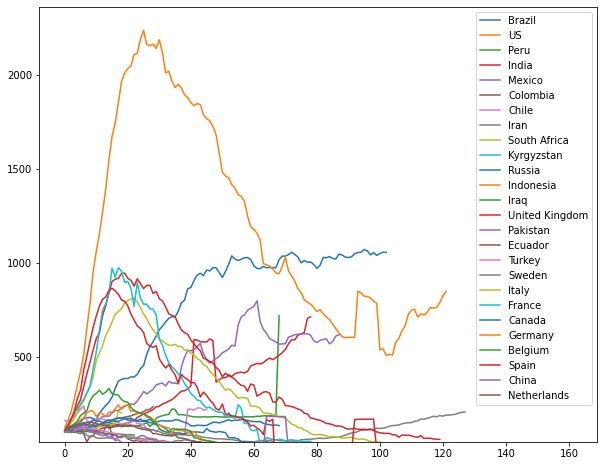

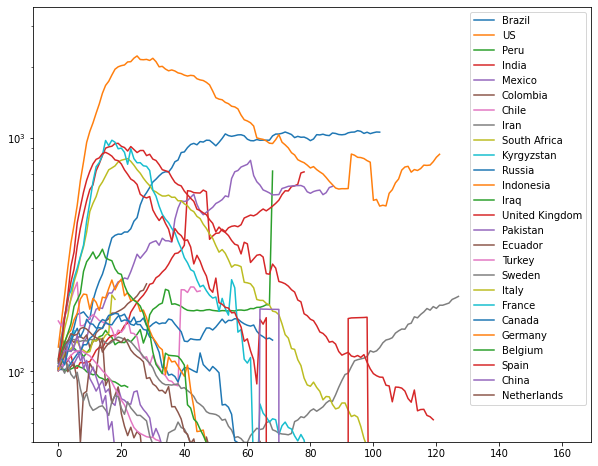

In [7]:
comparable_deaths.plot(legend='best', logy=False)
plt.ylim((50, plt.ylim()[1]))
comparable_deaths.plot(legend='best', logy=True)
plt.ylim((50, plt.ylim()[1]))

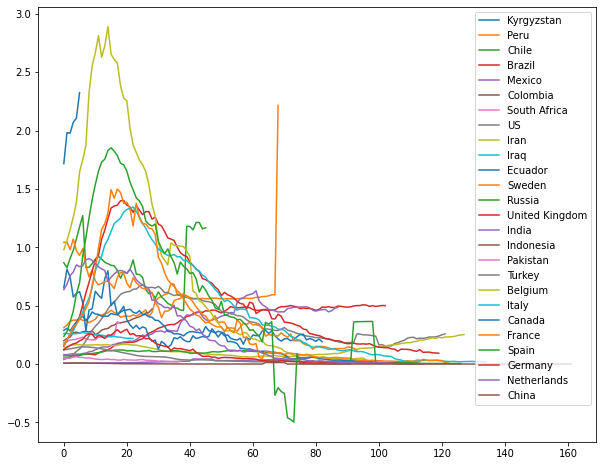

In [8]:
comparable_death_fraction = comparable_deaths.divide(pop_by_jhu, axis='columns').dropna(how='all', axis='columns')
comparable_death_fraction = comparable_death_fraction.reindex(columns=comparable_death_fraction.ffill().iloc[-1].sort_values(ascending=False).index)
comparable_death_fraction.plot(legend='best', logy=False)